Para o início do estudo de classificação, será usado o dataset MNIST, que consiste em um banco de dados de 70.000 pequenas imagens de dígitos manuscritos por estudantes do ensino médio e funcionários do US Census Bureau. 

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

**-DESCR** descreve o dataset

**-data** contém um array com uma linhapor instancia e uma coluna por feature

**-target** contém um array com as labels

In [2]:
X, y = mnist["data"], mnist["target"]

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

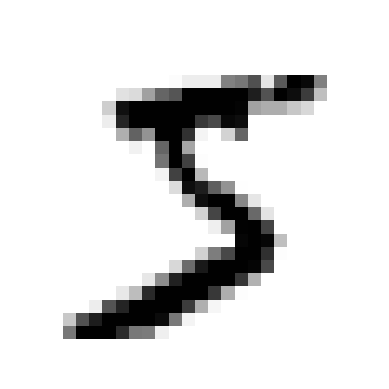

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis("off")
plt.show()

In [6]:
y[0]

'5'

As labels estão em formato de string, a maioria dos algoritmos de machine learning esperam um número, sendo assim, é preciso alterar o seu tipo.

In [7]:
import numpy as np

y = y.astype(np.uint8)

In [8]:
y[0]

5

Separando os dados em conjuntos de teste e treino

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**Treinando um classificador binário**

Será feito um classificador onde sua função será identificar o número 5 e o que não é o número 5

In [10]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)
y_test_5

array([False, False, False, ..., False,  True, False])

Usando o Stochastic Gradient Descent.

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [12]:
sgd_clf.predict([some_digit])

array([ True])

**Mensurando a Performance**

**Mensurando a acurácia usando Cross-Validation**

In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Antes de darmos continuidade, vamos usar um classificador básico, onde irá classificar os valores que não são 5.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

A função do código acima é criar um array inteiro de false, ele será usado para testar o modelo criado antes. A partir do valor da acurácia encontrada com este "Dummy", é possível termos uma baseline, ou seja, caso a acurácia encontrada for pior que a encontrada com o "Dummy", é possível afirmar que o modelo anterior é ruim. 

In [15]:
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Nossa linha de base será **0.90855**

Isso ocorre simplesmente porque apenas cerca de 10% das imagens são 5s, então se você sempre adivinhar que uma imagem não é um 5, você estará certo cerca de 90% das vezes.

Então como o classificador dummy teve uma acertividade de 90%, quando olhamos para o 96% do nosso modelos, vemos que esta acertividade, por mais que seja alta, não é lá essas coisas, para isso podemos usar outras métricas.

**Matriz de Confusão**

In [16]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

**53892** - corresponde ao verdadeiro negativo, ou seja, ele acertou que o número não é 5.

**687** - corresponde ao falso positivo, ou seja, ele confundiu um número X com o 5.

**1891** - corresponde ao falso negotivo, ou seja, ele confundiu dizendo que o 5 não era 5

**3530** - corresponde ao verdadeiro positivo, ou seja, ele acertou que o 5 era realmente o 5

Fazendo uma simulação de uma matriz de confusão perfeita.

In [18]:
y_train_perfect_predictions = y_train_5

confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

Vemos que em uma matriz de confusão perfeita, apenas a diagonal principal teria valores diferente de 0

**Precisão e recall**

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_predict)


0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

Olhando para estes resultados, vemos que a partir da acarácia, o nosso detector de 5's não é mais tão impressionante.

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7325171197343847

Analisando as pontuações das instanciações do modelo.

In [22]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [23]:
threshold = 0

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [24]:
threshold = 8000

y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

**Decidindo qual limiar usar no modelo**

In [25]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [26]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

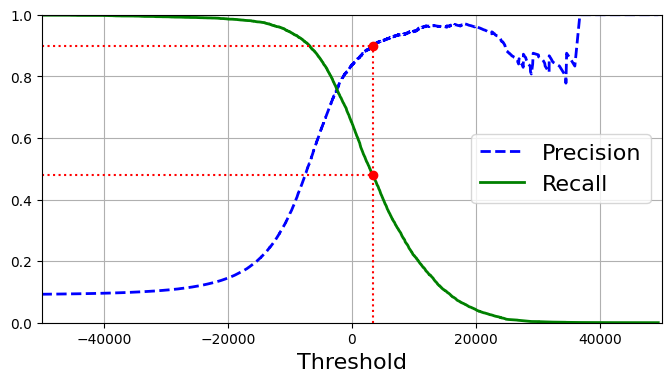

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

Escolhendo o menor limiar que dê uma precisão de 90%

In [29]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [30]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [31]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

Explicando o código acima:

np.argmax(precisions >= 0.90): pegará o primeiro valor que satisfaça a condição de >= a 90%

threshold_90_precision = thresholds: assim que encontrado o valor, guardará na variável o limiar correspondente

y_train_pred_90 = (y_scores >= threshold_90_precision): cria um array booleano onde toda vez que for true, corresponde ao y_score >= ao limiar encontrado

precision_score(y_train_5, y_train_pred_90): calcula a precisão comparando os rótulos reais ao array criado com o novo limiar

recall_score(y_train_5, y_train_pred_90): faz a mesma coisa, porém calculando o recall